### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *
from pprint import pprint
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

%matplotlib inline

#### Importing Dataset

In [2]:
ls

'2019 County Health Rankings Data - v2.xls'*   marc_index.ipynb
 analytic_data2019.csv*                        __pycache__/
 clean.csv                                     README.md
 external_modules/                             shuyu_index.ipynb
 functions.py


### If the cleaning process has already been done jump to import the cleaned csv later in the file

In [3]:
xls = pd.ExcelFile('2019 County Health Rankings Data - v2.xls')
df = pd.read_excel(xls, 'Additional Measure Data',skiprows=1)

In [4]:
df.head()

,FIPS,State,County,Life Expectancy,95% CI - Low,95% CI - High,Life Expectancy (Black),Life Expectancy (Hispanic),Life Expectancy (White),# Deaths,...,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,95% CI - Low.16,95% CI - High.16,% Female,# Rural,% Rural
0,1001,Alabama,Autauga,76.330589,75.554117,77.107061,74.600628,NaN,76.337219,815.0,...,2.857452,41336,74.473912,430,0.828548,0.422472,1.234624,51.342246,22921.0,42.002162
1,1003,Alabama,Baldwin,78.599498,78.208357,78.990639,75.628919,98.039893,78.537003,2827.0,...,4.550200,176582,83.047388,872,0.454512,0.282144,0.626880,51.452772,77060.0,42.279099
2,1005,Alabama,Barbour,75.779457,74.639355,76.919559,74.240228,NaN,77.568384,451.0,...,4.206569,11613,45.955679,297,1.199273,0.580536,1.818011,47.229917,18613.0,67.789635
3,1007,Alabama,Bibb,73.928271,72.624611,75.231931,72.294686,NaN,74.109510,445.0,...,2.638080,16842,74.298571,84,0.394348,0.000000,0.933361,46.453150,15663.0,68.352607
4,1009,Alabama,Blount,74.597767,73.810999,75.384535,NaN,78.577094,74.098247,1050.0,...,9.565097,50439,86.944306,1013,1.870004,1.364180,2.375829,50.688639,51562.0,89.951502


In [5]:
df.select_dtypes(include=['object'])[:2]

,State,County,Other PCP Ratio
0,Alabama,Autauga,3265:1
1,Alabama,Baldwin,1916:1


### Exploratory Data Analysis

#### Renaming columns

In [6]:
columns_name = df.columns
new_column_names = []
for column_name in columns_name:
    new_column_names.append(column_name.replace(" ", "_"))
pprint(new_column_names[:5])
df.columns = new_column_names

['FIPS', 'State', 'County', 'Life_Expectancy', '95%_CI_-_Low']


#### Renaming counties

In [7]:
county_names = df["County"]
new_county_names = []
for county_name in county_names:
    new_county_names.append(county_name.replace(" ", "_"))
df["County"] = new_county_names

#### Dropping ethnicies columns and columns with a lot of missing values

In [8]:
to_drop = ["Other_PCP_Ratio", "FIPS", "Segregation_index", "Segregation_Index" , "%_Free_or_Reduced_Lunch", "#_HIV_Cases", "HIV_Prevalence_Rate"]
#Data is missing for HIV only in South Dakota, replace it by country weighted average later or look at this column in depth
containing = ["CI_-_Low", "CI_-_High", "#_","White", "Hispanic", "Black", "Asian" ,"Alaskan", "Indian", "Hawaiian", "African"]
for column in df.columns:
    if (column in to_drop) or any(word in column for word in containing):
        df = df.drop([column], axis=1)

In [9]:
df.columns

Index(['State', 'County', 'Life_Expectancy', 'Age-Adjusted_Mortality',
       'Child_Mortality_Rate', 'Infant_Mortality_Rate',
       '%_Frequent_Physical_Distress', '%_Frequent_Mental_Distress',
       '%_Diabetic', '%_Food_Insecure', '%_Limited_Access',
       'Drug_Overdose_Mortality_Rate', 'MV_Mortality_Rate',
       '%_Insufficient_Sleep', '%_Uninsured', '%_Uninsured.1',
       'Other_PCP_Rate', '%_Disconnected_Youth', 'Household_Income',
       'Homicide_Rate', 'Firearm_Fatalities_Rate', '%_Homeowners',
       '%_Severe_Housing_Cost_Burden', 'Population', '%_<_18', '%_65_and_over',
       '%_Not_Proficient_in_English', '%_Female', '%_Rural'],
      dtype='object')

In [10]:
#Not necessary --> df["%_18_and_<_65"] = 100 - (df["%_<_18"] + df["%_65_and_over"])

In [11]:
ren_col = {"Household_Income": "Household_Median_Income",
           "%_Uninsured": "%_Uninsured_adults",
           "%_Uninsured.1" : "%_Uninsured_children",
           "%_Limited_Access": "%_Limited_Access_Healthy_Food"}

In [12]:
df.rename(columns=ren_col, inplace=True)

#### Delete rows missing Life Expectancy

In [13]:
df = df.dropna(subset=["Life_Expectancy"])

### Fill counties missing values using states weighted averages

In [14]:
df.head(2)

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099


#### Calculate the weighted averages for each columns in each states

In [15]:
states = list(df.State.unique())
columns = [x for x in list(df.columns) if x not in ["State", "County"]]

In [16]:
state_wv = {}
for state in states:
    df_state = df.loc[df["State"] == state]
    for column in columns:
        values = df_state.dropna(subset=[column])[column]
        population_value = df_state.dropna(subset=[column])["Population"].astype(np.float64)
        population = np.sum(df_state.dropna(subset=[column])["Population"])
        if population != 0:
            wv = (values * population_value).sum() / population
            if not state_wv.get(state):
                state_wv[state] = {}
            state_wv[state][column] = float(wv)
        else:
            print(f"No data for {column} in {state}")

#### Fill each missing values by states weighted averages

In [17]:
df_filled = df.copy()
for index in df.index:
    for column in df.columns:
        if column not in ["State","County"]:
            if np.isnan(df[column][index]):
                df_filled[column][index] = state_wv[df["State"][index]][column]

/home/locsta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
df_filled.head()

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099
2,Alabama,Barbour,75.779457,469.8,77.080027,8.444680,16.216160,14.632311,18.0,23.2,...,7.0,15.2,62.506800,13.586765,25270,20.763751,18.824693,1.199273,47.229917,67.789635
3,Alabama,Bibb,73.928271,563.7,111.749681,14.792899,13.162968,12.854036,14.9,15.8,...,8.2,21.3,75.361481,8.733889,22668,20.606141,16.022587,0.394348,46.453150,68.352607
4,Alabama,Blount,74.597767,501.8,76.032935,6.184688,13.720057,13.827943,14.3,11.0,...,7.4,19.7,78.521025,8.194495,58013,23.349939,17.842553,1.870004,50.688639,89.951502


#### Saving cleaned DataFrame to csv file

In [19]:
df_filled.to_csv(r"/home/locsta/Documents/FlatIron/County-Health-Analysis/clean.csv", index=False)

### Importing Cleaned CSV

In [2]:
df = pd.read_csv("clean.csv")
df.head()

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099
2,Alabama,Barbour,75.779457,469.8,77.080027,8.444680,16.216160,14.632311,18.0,23.2,...,7.0,15.2,62.506800,13.586765,25270,20.763751,18.824693,1.199273,47.229917,67.789635
3,Alabama,Bibb,73.928271,563.7,111.749681,14.792899,13.162968,12.854036,14.9,15.8,...,8.2,21.3,75.361481,8.733889,22668,20.606141,16.022587,0.394348,46.453150,68.352607
4,Alabama,Blount,74.597767,501.8,76.032935,6.184688,13.720057,13.827943,14.3,11.0,...,7.4,19.7,78.521025,8.194495,58013,23.349939,17.842553,1.870004,50.688639,89.951502


# TODO Check for homoscedaticity and normality
https://github.com/learn-co-students/dsc-modeling-your-data-lab-london-ds-111819/tree/solution

#### Plot variables distribution

In [3]:
for i, column in enumerate(df.drop(["State"], axis=1).columns):
    plt.figure(i)
    min_x = (df[column].mean()-(2*df[column].std()))
    max_x = (df[column].mean()+(2*df[column].std()))
    sns.kdeplot(df[column], clip=(min_x, max_x))

TypeError: Could not convert AutaugaBaldwinBarbourBibbBlountBullockButlerCalhounChambersCherokeeChiltonChoctawClarkeClayCleburneCoffeeColbertConecuhCoosaCovingtonCrenshawCullmanDaleDallasDeKalbElmoreEscambiaEtowahFayetteFranklinGenevaGreeneHaleHenryHoustonJacksonJeffersonLamarLauderdaleLawrenceLeeLimestoneLowndesMaconMadisonMarengoMarionMarshallMobileMonroeMontgomeryMorganPerryPickensPikeRandolphRussellSt._ClairShelbySumterTalladegaTallapoosaTuscaloosaWalkerWashingtonWilcoxWinstonAleutians_EastAleutians_WestAnchorageBethelDenaliDillinghamFairbanks_North_StarHainesHoonah-AngoonJuneauKenai_PeninsulaKetchikan_GatewayKodiak_IslandKusilvakMatanuska-SusitnaNomeNorth_SlopeNorthwest_ArcticPetersburgPrince_of_Wales-HyderSitkaSoutheast_FairbanksValdez-CordovaWrangellYukon-KoyukukApacheCochiseCoconinoGilaGrahamGreenleeLa_PazMaricopaMohaveNavajoPimaPinalSanta_CruzYavapaiYumaArkansasAshleyBaxterBentonBooneBradleyCalhounCarrollChicotClarkClayCleburneClevelandColumbiaConwayCraigheadCrawfordCrittendenCrossDallasDeshaDrewFaulknerFranklinFultonGarlandGrantGreeneHempsteadHot_SpringHowardIndependenceIzardJacksonJeffersonJohnsonLafayetteLawrenceLeeLincolnLittle_RiverLoganLonokeMadisonMarionMillerMississippiMonroeMontgomeryNevadaNewtonOuachitaPerryPhillipsPikePoinsettPolkPopePrairiePulaskiRandolphSt._FrancisSalineScottSearcySebastianSevierSharpStoneUnionVan_BurenWashingtonWhiteWoodruffYellAlamedaAmadorButteCalaverasColusaContra_CostaDel_NorteEl_DoradoFresnoGlennHumboldtImperialInyoKernKingsLakeLassenLos_AngelesMaderaMarinMariposaMendocinoMercedModocMonoMontereyNapaNevadaOrangePlacerPlumasRiversideSacramentoSan_BenitoSan_BernardinoSan_DiegoSan_FranciscoSan_JoaquinSan_Luis_ObispoSan_MateoSanta_BarbaraSanta_ClaraSanta_CruzShastaSierraSiskiyouSolanoSonomaStanislausSutterTehamaTrinityTulareTuolumneVenturaYoloYubaAdamsAlamosaArapahoeArchuletaBacaBentBoulderBroomfieldChaffeeCheyenneClear_CreekConejosCostillaCrowleyCusterDeltaDenverDoloresDouglasEagleElbertEl_PasoFremontGarfieldGilpinGrandGunnisonHuerfanoJeffersonKit_CarsonLakeLa_PlataLarimerLas_AnimasLincolnLoganMesaMoffatMontezumaMontroseMorganOteroOurayParkPhillipsPitkinProwersPuebloRio_BlancoRio_GrandeRouttSaguacheSan_MiguelSedgwickSummitTellerWashingtonWeldYumaFairfieldHartfordLitchfieldMiddlesexNew_HavenNew_LondonTollandWindhamKentNew_CastleSussexDistrict_of_ColumbiaAlachuaBakerBayBradfordBrevardBrowardCalhounCharlotteCitrusClayCollierColumbiaDeSotoDixieDuvalEscambiaFlaglerFranklinGadsdenGilchristGladesGulfHamiltonHardeeHendryHernandoHighlandsHillsboroughHolmesIndian_RiverJacksonJeffersonLafayetteLakeLeeLeonLevyLibertyMadisonManateeMarionMartinMiami-DadeMonroeNassauOkaloosaOkeechobeeOrangeOsceolaPalm_BeachPascoPinellasPolkPutnamSt._JohnsSt._LucieSanta_RosaSarasotaSeminoleSumterSuwanneeTaylorUnionVolusiaWakullaWaltonWashingtonApplingAtkinsonBaconBakerBaldwinBanksBarrowBartowBen_HillBerrienBibbBleckleyBrantleyBrooksBryanBullochBurkeButtsCalhounCamdenCandlerCarrollCatoosaCharltonChathamChattahoocheeChattoogaCherokeeClarkeClayClaytonClinchCobbCoffeeColquittColumbiaCookCowetaCrawfordCrispDadeDawsonDecaturDeKalbDodgeDoolyDoughertyDouglasEarlyEcholsEffinghamElbertEmanuelEvansFanninFayetteFloydForsythFranklinFultonGilmerGlascockGlynnGordonGradyGreeneGwinnettHabershamHallHancockHaralsonHarrisHartHeardHenryHoustonIrwinJacksonJasperJeff_DavisJeffersonJenkinsJohnsonJonesLamarLanierLaurensLeeLibertyLincolnLongLowndesLumpkinMcDuffieMcIntoshMaconMadisonMarionMeriwetherMillerMitchellMonroeMontgomeryMorganMurrayMuscogeeNewtonOconeeOglethorpePauldingPeachPickensPiercePikePolkPulaskiPutnamQuitmanRabunRandolphRichmondRockdaleSchleyScrevenSeminoleSpaldingStephensStewartSumterTalbotTattnallTaylorTelfairTerrellThomasTiftToombsTownsTreutlenTroupTurnerTwiggsUnionUpsonWalkerWaltonWareWarrenWashingtonWayneWebsterWheelerWhiteWhitfieldWilcoxWilkesWilkinsonWorthHawaiiHonoluluKauaiMauiAdaAdamsBannockBear_LakeBenewahBinghamBlaineBoiseBonnerBonnevilleBoundaryButteCanyonCaribouCassiaClearwaterCusterElmoreFranklinFremontGemGoodingIdahoJeffersonJeromeKootenaiLatahLemhiLewisLincolnMadisonMinidokaNez_PerceOneidaOwyheePayettePowerShoshoneTetonTwin_FallsValleyWashingtonAdamsAlexanderBondBooneBrownBureauCalhounCarrollCassChampaignChristianClarkClayClintonColesCookCrawfordCumberlandDeKalbDe_WittDouglasDuPageEdgarEdwardsEffinghamFayetteFordFranklinFultonGallatinGreeneGrundyHamiltonHancockHardinHendersonHenryIroquoisJacksonJasperJeffersonJerseyJo_DaviessJohnsonKaneKankakeeKendallKnoxLakeLaSalleLawrenceLeeLivingstonLoganMcDonoughMcHenryMcLeanMaconMacoupinMadisonMarionMarshallMasonMassacMenardMercerMonroeMontgomeryMorganMoultrieOglePeoriaPerryPiattPikePopePulaskiPutnamRandolphRichlandRock_IslandSt._ClairSalineSangamonSchuylerScottShelbyStarkStephensonTazewellUnionVermilionWabashWarrenWashingtonWayneWhiteWhitesideWillWilliamsonWinnebagoWoodfordAdamsAllenBartholomewBentonBlackfordBooneBrownCarrollCassClarkClayClintonCrawfordDaviessDearbornDecaturDeKalbDelawareDuboisElkhartFayetteFloydFountainFranklinFultonGibsonGrantGreeneHamiltonHancockHarrisonHendricksHenryHowardHuntingtonJacksonJasperJayJeffersonJenningsJohnsonKnoxKosciuskoLaGrangeLakeLaPorteLawrenceMadisonMarionMarshallMartinMiamiMonroeMontgomeryMorganNewtonNobleOhioOrangeOwenParkePerryPikePorterPoseyPulaskiPutnamRandolphRipleyRushSt._JosephScottShelbySpencerStarkeSteubenSullivanSwitzerlandTippecanoeTiptonUnionVanderburghVermillionVigoWabashWarrenWarrickWashingtonWayneWellsWhiteWhitleyAdairAdamsAllamakeeAppanooseAudubonBentonBlack_HawkBooneBremerBuchananBuena_VistaButlerCalhounCarrollCassCedarCerro_GordoCherokeeChickasawClarkeClayClaytonClintonCrawfordDallasDavisDecaturDelawareDes_MoinesDickinsonDubuqueEmmetFayetteFloydFranklinFremontGreeneGrundyGuthrieHamiltonHancockHardinHarrisonHenryHowardHumboldtIdaIowaJacksonJasperJeffersonJohnsonJonesKeokukKossuthLeeLinnLouisaLucasLyonMadisonMahaskaMarionMarshallMillsMitchellMononaMonroeMontgomeryMuscatineO'BrienOsceolaPagePalo_AltoPlymouthPocahontasPolkPottawattamiePoweshiekRinggoldSacScottShelbySiouxStoryTamaTaylorUnionVan_BurenWapelloWarrenWashingtonWayneWebsterWinnebagoWinneshiekWoodburyWorthWrightAllenAndersonAtchisonBarberBartonBourbonBrownButlerChaseChautauquaCherokeeCheyenneClarkClayCloudCoffeyComancheCowleyCrawfordDecaturDickinsonDoniphanDouglasEdwardsElkEllisEllsworthFinneyFordFranklinGearyGoveGrahamGrantGrayGreenwoodHamiltonHarperHarveyHaskellHodgemanJacksonJeffersonJewellJohnsonKearnyKingmanKiowaLabetteLeavenworthLincolnLinnLoganLyonMcPhersonMarionMarshallMeadeMiamiMitchellMontgomeryMorrisMortonNemahaNeoshoNessNortonOsageOsborneOttawaPawneePhillipsPottawatomiePrattRawlinsRenoRepublicRiceRileyRooksRushRussellSalineScottSedgwickSewardShawneeSheridanShermanSmithStaffordStantonStevensSumnerThomasTregoWabaunseeWashingtonWichitaWilsonWoodsonWyandotteAdairAllenAndersonBallardBarrenBathBellBooneBourbonBoydBoyleBrackenBreathittBreckinridgeBullittButlerCaldwellCallowayCampbellCarlisleCarrollCarterCaseyChristianClarkClayClintonCrittendenCumberlandDaviessEdmonsonElliottEstillFayetteFlemingFloydFranklinFultonGallatinGarrardGrantGravesGraysonGreenGreenupHancockHardinHarlanHarrisonHartHendersonHenryHickmanHopkinsJacksonJeffersonJessamineJohnsonKentonKnottKnoxLarueLaurelLawrenceLeeLeslieLetcherLewisLincolnLivingstonLoganLyonMcCrackenMcCrearyMcLeanMadisonMagoffinMarionMarshallMartinMasonMeadeMenifeeMercerMetcalfeMonroeMontgomeryMorganMuhlenbergNelsonNicholasOhioOldhamOwenOwsleyPendletonPerryPikePowellPulaskiRobertsonRockcastleRowanRussellScottShelbySimpsonSpencerTaylorToddTriggTrimbleUnionWarrenWashingtonWayneWebsterWhitleyWolfeWoodfordAcadiaAllenAscensionAssumptionAvoyellesBeauregardBienvilleBossierCaddoCalcasieuCaldwellCameronCatahoulaClaiborneConcordiaDe_SotoEast_Baton_RougeEast_CarrollEast_FelicianaEvangelineFranklinGrantIberiaIbervilleJacksonJeffersonJefferson_DavisLafayetteLafourcheLa_SalleLincolnLivingstonMadisonMorehouseNatchitochesOrleansOuachitaPlaqueminesPointe_CoupeeRapidesRed_RiverRichlandSabineSt._BernardSt._CharlesSt._HelenaSt._JamesSt._John_the_BaptistSt._LandrySt._MartinSt._MarySt._TammanyTangipahoaTensasTerrebonneUnionVermilionVernonWashingtonWebsterWest_Baton_RougeWest_CarrollWest_FelicianaWinnAndroscogginAroostookCumberlandFranklinHancockKennebecKnoxLincolnOxfordPenobscotPiscataquisSagadahocSomersetWaldoWashingtonYorkAlleganyAnne_ArundelBaltimoreCalvertCarolineCarrollCecilCharlesDorchesterFrederickGarrettHarfordHowardKentMontgomeryPrince_George'sQueen_Anne'sSt._Mary'sSomersetTalbotWashingtonWicomicoWorcesterBaltimore_CityBarnstableBerkshireBristolDukesEssexFranklinHampdenHampshireMiddlesexNantucketNorfolkPlymouthSuffolkWorcesterAlconaAlgerAlleganAlpenaAntrimArenacBaragaBarryBayBenzieBerrienBranchCalhounCassCharlevoixCheboyganChippewaClareClintonCrawfordDeltaDickinsonEatonEmmetGeneseeGladwinGogebicGrand_TraverseGratiotHillsdaleHoughtonHuronInghamIoniaIoscoIronIsabellaJacksonKalamazooKalkaskaKentKeweenawLakeLapeerLeelanauLenaweeLivingstonLuceMackinacMacombManisteeMarquetteMasonMecostaMenomineeMidlandMissaukeeMonroeMontcalmMontmorencyMuskegonNewaygoOaklandOceanaOgemawOntonagonOsceolaOscodaOtsegoOttawaPresque_IsleRoscommonSaginawSt._ClairSt._JosephSanilacSchoolcraftShiawasseeTuscolaVan_BurenWashtenawWayneWexfordAitkinAnokaBeckerBeltramiBentonBig_StoneBlue_EarthBrownCarltonCarverCassChippewaChisagoClayClearwaterCookCottonwoodCrow_WingDakotaDodgeDouglasFaribaultFillmoreFreebornGoodhueGrantHennepinHoustonHubbardIsantiItascaJacksonKanabecKandiyohiKittsonKoochichingLac_qui_ParleLakeLake_of_the_WoodsLe_SueurLincolnLyonMcLeodMahnomenMarshallMartinMeekerMille_LacsMorrisonMowerMurrayNicolletNoblesNormanOlmstedOtter_TailPenningtonPinePipestonePolkPopeRamseyRed_LakeRedwoodRenvilleRiceRockRoseauSt._LouisScottSherburneSibleyStearnsSteeleStevensSwiftToddTraverseWabashaWadenaWasecaWashingtonWatonwanWilkinWinonaWrightYellow_MedicineAdamsAlcornAmiteAttalaBentonBolivarCalhounCarrollChickasawChoctawClaiborneClarkeClayCoahomaCopiahCovingtonDeSotoForrestFranklinGeorgeGreeneGrenadaHancockHarrisonHindsHolmesHumphreysItawambaJacksonJasperJeffersonJefferson_DavisJonesKemperLafayetteLamarLauderdaleLawrenceLeakeLeeLefloreLincolnLowndesMadisonMarionMarshallMonroeMontgomeryNeshobaNewtonNoxubeeOktibbehaPanolaPearl_RiverPerryPikePontotocPrentissQuitmanRankinScottSharkeySimpsonSmithStoneSunflowerTallahatchieTateTippahTishomingoTunicaUnionWalthallWarrenWashingtonWayneWebsterWilkinsonWinstonYalobushaYazooAdairAndrewAtchisonAudrainBarryBartonBatesBentonBollingerBooneBuchananButlerCaldwellCallawayCamdenCape_GirardeauCarrollCarterCassCedarCharitonChristianClarkClayClintonColeCooperCrawfordDadeDallasDaviessDeKalbDentDouglasDunklinFranklinGasconadeGentryGreeneGrundyHarrisonHenryHickoryHoltHowardHowellIronJacksonJasperJeffersonJohnsonKnoxLacledeLafayetteLawrenceLewisLincolnLinnLivingstonMcDonaldMaconMadisonMariesMarionMercerMillerMississippiMoniteauMonroeMontgomeryMorganNew_MadridNewtonNodawayOregonOsageOzarkPemiscotPerryPettisPhelpsPikePlattePolkPulaskiPutnamRallsRandolphRayReynoldsRipleySt._CharlesSt._ClairSte._GenevieveSt._FrancoisSt._LouisSalineSchuylerScotlandScottShannonShelbyStoddardStoneSullivanTaneyTexasVernonWarrenWashingtonWayneWebsterWorthWrightSt._Louis_CityBeaverheadBig_HornBlaineBroadwaterCarbonCascadeChouteauCusterDanielsDawsonDeer_LodgeFallonFergusFlatheadGallatinGlacierGraniteHillJeffersonJudith_BasinLakeLewis_and_ClarkLibertyLincolnMcConeMadisonMeagherMineralMissoulaMusselshellParkPhillipsPonderaPowder_RiverPowellRavalliRichlandRooseveltRosebudSandersSheridanSilver_BowStillwaterSweet_GrassTetonTooleValleyWheatlandYellowstoneAdamsAntelopeBooneBox_ButteBoydBrownBuffaloBurtButlerCassCedarChaseCherryCheyenneClayColfaxCumingCusterDakotaDawesDawsonDeuelDixonDodgeDouglasDundyFillmoreFranklinFrontierFurnasGageGardenGarfieldGosperGreeleyHallHamiltonHarlanHitchcockHoltHowardJeffersonJohnsonKearneyKeithKimballKnoxLancasterLincolnMadisonMerrickMorrillNanceNemahaNuckollsOtoePawneePerkinsPhelpsPiercePlattePolkRed_WillowRichardsonSalineSarpySaundersScotts_BluffSewardSheridanShermanStantonThayerThurstonValleyWashingtonWayneWebsterYorkChurchillClarkDouglasElkoEurekaHumboldtLanderLincolnLyonMineralNyePershingStoreyWashoeWhite_PineCarson_CityBelknapCarrollCheshireCoosGraftonHillsboroughMerrimackRockinghamStraffordSullivanAtlanticBergenBurlingtonCamdenCape_MayCumberlandEssexGloucesterHudsonHunterdonMercerMiddlesexMonmouthMorrisOceanPassaicSalemSomersetSussexUnionWarrenBernalilloCatronChavesCibolaColfaxCurryDe_BacaDona_AnaEddyGrantGuadalupeHidalgoLeaLincolnLos_AlamosLunaMcKinleyMoraOteroQuayRio_ArribaRooseveltSandovalSan_JuanSan_MiguelSanta_FeSierraSocorroTaosTorranceUnionValenciaAlbanyAlleganyBronxBroomeCattaraugusCayugaChautauquaChemungChenangoClintonColumbiaCortlandDelawareDutchessErieEssexFranklinFultonGeneseeGreeneHamiltonHerkimerJeffersonKingsLewisLivingstonMadisonMonroeMontgomeryNassauNew_YorkNiagaraOneidaOnondagaOntarioOrangeOrleansOswegoOtsegoPutnamQueensRensselaerRichmondRocklandSt._LawrenceSaratogaSchenectadySchoharieSchuylerSenecaSteubenSuffolkSullivanTiogaTompkinsUlsterWarrenWashingtonWayneWestchesterWyomingYatesAlamanceAlexanderAlleghanyAnsonAsheAveryBeaufortBertieBladenBrunswickBuncombeBurkeCabarrusCaldwellCamdenCarteretCaswellCatawbaChathamCherokeeChowanClayClevelandColumbusCravenCumberlandCurrituckDareDavidsonDavieDuplinDurhamEdgecombeForsythFranklinGastonGatesGrahamGranvilleGreeneGuilfordHalifaxHarnettHaywoodHendersonHertfordHokeHydeIredellJacksonJohnstonJonesLeeLenoirLincolnMcDowellMaconMadisonMartinMecklenburgMitchellMontgomeryMooreNashNew_HanoverNorthamptonOnslowOrangePamlicoPasquotankPenderPerquimansPersonPittPolkRandolphRichmondRobesonRockinghamRowanRutherfordSampsonScotlandStanlyStokesSurrySwainTransylvaniaTyrrellUnionVanceWakeWarrenWashingtonWataugaWayneWilkesWilsonYadkinYanceyAdamsBarnesBensonBottineauBowmanBurkeBurleighCassCavalierDickeyDivideDunnEddyEmmonsFosterGolden_ValleyGrand_ForksGrantGriggsHettingerKidderLaMoureLoganMcHenryMcIntoshMcKenzieMcLeanMercerMortonMountrailNelsonOliverPembinaPierceRamseyRansomRenvilleRichlandRoletteSargentSiouxStarkSteeleStutsmanTownerTraillWalshWardWellsWilliamsAdamsAllenAshlandAshtabulaAthensAuglaizeBelmontBrownButlerCarrollChampaignClarkClermontClintonColumbianaCoshoctonCrawfordCuyahogaDarkeDefianceDelawareErieFairfieldFayetteFranklinFultonGalliaGeaugaGreeneGuernseyHamiltonHancockHardinHarrisonHenryHighlandHockingHolmesHuronJacksonJeffersonKnoxLakeLawrenceLickingLoganLorainLucasMadisonMahoningMarionMedinaMeigsMercerMiamiMonroeMontgomeryMorganMorrowMuskingumNobleOttawaPauldingPerryPickawayPikePortagePreblePutnamRichlandRossSanduskySciotoSenecaShelbyStarkSummitTrumbullTuscarawasUnionVan_WertVintonWarrenWashingtonWayneWilliamsWoodWyandotAdairAlfalfaAtokaBeaverBeckhamBlaineBryanCaddoCanadianCarterCherokeeChoctawCimarronClevelandCoalComancheCottonCraigCreekCusterDelawareDeweyEllisGarfieldGarvinGradyGrantGreerHarmonHarperHaskellHughesJacksonJeffersonJohnstonKayKingfisherKiowaLatimerLe_FloreLincolnLoganLoveMcClainMcCurtainMcIntoshMajorMarshallMayesMurrayMuskogeeNobleNowataOkfuskeeOklahomaOkmulgeeOsageOttawaPawneePaynePittsburgPontotocPottawatomiePushmatahaRoger_MillsRogersSeminoleSequoyahStephensTexasTillmanTulsaWagonerWashingtonWashitaWoodsWoodwardBakerBentonClackamasClatsopColumbiaCoosCrookCurryDeschutesDouglasGilliamGrantHarneyHood_RiverJacksonJeffersonJosephineKlamathLakeLaneLincolnLinnMalheurMarionMorrowMultnomahPolkShermanTillamookUmatillaUnionWallowaWascoWashingtonYamhillAdamsAlleghenyArmstrongBeaverBedfordBerksBlairBradfordBucksButlerCambriaCameronCarbonCentreChesterClarionClearfieldClintonColumbiaCrawfordCumberlandDauphinDelawareElkErieFayetteForestFranklinFultonGreeneHuntingdonIndianaJeffersonJuniataLackawannaLancasterLawrenceLebanonLehighLuzerneLycomingMcKeanMercerMifflinMonroeMontgomeryMontourNorthamptonNorthumberlandPerryPhiladelphiaPikePotterSchuylkillSnyderSomersetSullivanSusquehannaTiogaUnionVenangoWarrenWashingtonWayneWestmorelandWyomingYorkBristolKentNewportProvidenceWashingtonAbbevilleAikenAllendaleAndersonBambergBarnwellBeaufortBerkeleyCalhounCharlestonCherokeeChesterChesterfieldClarendonColletonDarlingtonDillonDorchesterEdgefieldFairfieldFlorenceGeorgetownGreenvilleGreenwoodHamptonHorryJasperKershawLancasterLaurensLeeLexingtonMcCormickMarionMarlboroNewberryOconeeOrangeburgPickensRichlandSaludaSpartanburgSumterUnionWilliamsburgYorkAuroraBeadleBennettBon_HommeBrookingsBrownBruleBuffaloButteCharles_MixClarkClayCodingtonCorsonCusterDavisonDayDeuelDeweyDouglasEdmundsFall_RiverFaulkGrantGregoryHaakonHamlinHandHansonHughesHutchinsonJacksonJerauldKingsburyLakeLawrenceLincolnLymanMcCookMcPhersonMarshallMeadeMelletteMinerMinnehahaMoodyOglala_LakotaPenningtonPerkinsPotterRobertsSanbornSpinkStanleyToddTrippTurnerUnionWalworthYanktonZiebachAndersonBedfordBentonBledsoeBlountBradleyCampbellCannonCarrollCarterCheathamChesterClaiborneClayCockeCoffeeCrockettCumberlandDavidsonDecaturDeKalbDicksonDyerFayetteFentressFranklinGibsonGilesGraingerGreeneGrundyHamblenHamiltonHancockHardemanHardinHawkinsHaywoodHendersonHenryHickmanHoustonHumphreysJacksonJeffersonJohnsonKnoxLakeLauderdaleLawrenceLewisLincolnLoudonMcMinnMcNairyMaconMadisonMarionMarshallMauryMeigsMonroeMontgomeryMooreMorganObionOvertonPerryPickettPolkPutnamRheaRoaneRobertsonRutherfordScottSequatchieSevierShelbySmithStewartSullivanSumnerTiptonTrousdaleUnicoiUnionVan_BurenWarrenWashingtonWayneWeakleyWhiteWilliamsonWilsonAndersonAndrewsAngelinaAransasArcherArmstrongAtascosaAustinBaileyBanderaBastropBaylorBeeBellBexarBlancoBosqueBowieBrazoriaBrazosBrewsterBrooksBrownBurlesonBurnetCaldwellCalhounCallahanCameronCampCarsonCassCastroChambersCherokeeChildressClayCochranCokeColemanCollinCollingsworthColoradoComalComancheConchoCookeCoryellCraneCrockettCrosbyCulbersonDallamDallasDawsonDeaf_SmithDeltaDentonDeWittDickensDimmitDonleyDuvalEastlandEctorEdwardsEllisEl_PasoErathFallsFanninFayetteFisherFloydFort_BendFranklinFreestoneFrioGainesGalvestonGarzaGillespieGoliadGonzalesGrayGraysonGreggGrimesGuadalupeHaleHallHamiltonHansfordHardemanHardinHarrisHarrisonHartleyHaskellHaysHemphillHendersonHidalgoHillHockleyHoodHopkinsHoustonHowardHudspethHuntHutchinsonJackJacksonJasperJeff_DavisJeffersonJim_HoggJim_WellsJohnsonJonesKarnesKaufmanKendallKerrKimbleKinneyKlebergKnoxLamarLambLampasasLa_SalleLavacaLeeLeonLibertyLimestoneLipscombLive_OakLlanoLubbockLynnMcCullochMcLennanMadisonMarionMartinMasonMatagordaMaverickMedinaMenardMidlandMilamMillsMitchellMontagueMontgomeryMooreMorrisNacogdochesNavarroNewtonNolanNuecesOchiltreeOldhamOrangePalo_PintoPanolaParkerParmerPecosPolkPotterPresidioRainsRandallReaganRealRed_RiverReevesRefugioRobertsonRockwallRunnelsRuskSabineSan_AugustineSan_JacintoSan_PatricioSan_SabaSchleicherScurryShackelfordShelbyShermanSmithSomervellStarrStephensSuttonSwisherTarrantTaylorTerryTitusTom_GreenTravisTrinityTylerUpshurUptonUvaldeVal_VerdeVan_ZandtVictoriaWalkerWallerWardWashingtonWebbWhartonWheelerWichitaWilbargerWillacyWilliamsonWilsonWinklerWiseWoodYoakumYoungZapataZavalaBeaverBox_ElderCacheCarbonDavisDuchesneEmeryGarfieldGrandIronJuabKaneMillardMorganRichSalt_LakeSan_JuanSanpeteSevierSummitTooeleUintahUtahWasatchWashingtonWayneWeberAddisonBenningtonCaledoniaChittendenEssexFranklinGrand_IsleLamoilleOrangeOrleansRutlandWashingtonWindhamWindsorAccomackAlbemarleAlleghanyAmeliaAmherstAppomattoxArlingtonAugustaBathBedfordBlandBotetourtBrunswickBuchananBuckinghamCampbellCarolineCarrollCharles_CityCharlotteChesterfieldClarkeCraigCulpeperCumberlandDickensonDinwiddieEssexFairfaxFauquierFloydFluvannaFranklinFrederickGilesGloucesterGoochlandGraysonGreeneGreensvilleHalifaxHanoverHenricoHenryHighlandIsle_of_WightJames_CityKing_and_QueenKing_GeorgeKing_WilliamLancasterLeeLoudounLouisaLunenburgMadisonMathewsMecklenburgMiddlesexMontgomeryNelsonNew_KentNorthamptonNorthumberlandNottowayOrangePagePatrickPittsylvaniaPowhatanPrince_EdwardPrince_GeorgePrince_WilliamPulaskiRappahannockRichmondRoanokeRockbridgeRockinghamRussellScottShenandoahSmythSouthamptonSpotsylvaniaStaffordSurrySussexTazewellWarrenWashingtonWestmorelandWiseWytheYorkAlexandria_CityBristol_CityBuena_Vista_CityCharlottesville_CityChesapeake_CityColonial_Heights_CityCovington_CityDanville_CityEmporia_CityFairfax_CityFalls_Church_CityFranklin_CityFredericksburg_CityGalax_CityHampton_CityHarrisonburg_CityHopewell_CityLexington_CityLynchburg_CityManassas_CityManassas_Park_CityMartinsville_CityNewport_News_CityNorfolk_CityNorton_CityPetersburg_CityPoquoson_CityPortsmouth_CityRadford_CityRichmond_CityRoanoke_CitySalem_CityStaunton_CitySuffolk_CityVirginia_Beach_CityWaynesboro_CityWilliamsburg_CityWinchester_CityAdamsAsotinBentonChelanClallamClarkColumbiaCowlitzDouglasFerryFranklinGarfieldGrantGrays_HarborIslandJeffersonKingKitsapKittitasKlickitatLewisLincolnMasonOkanoganPacificPend_OreillePierceSan_JuanSkagitSkamaniaSnohomishSpokaneStevensThurstonWahkiakumWalla_WallaWhatcomWhitmanYakimaBarbourBerkeleyBooneBraxtonBrookeCabellCalhounClayDoddridgeFayetteGilmerGrantGreenbrierHampshireHancockHardyHarrisonJacksonJeffersonKanawhaLewisLincolnLoganMcDowellMarionMarshallMasonMercerMineralMingoMonongaliaMonroeMorganNicholasOhioPendletonPleasantsPocahontasPrestonPutnamRaleighRandolphRitchieRoaneSummersTaylorTuckerTylerUpshurWayneWebsterWetzelWirtWoodWyomingAdamsAshlandBarronBayfieldBrownBuffaloBurnettCalumetChippewaClarkColumbiaCrawfordDaneDodgeDoorDouglasDunnEau_ClaireFlorenceFond_du_LacForestGrantGreenGreen_LakeIowaIronJacksonJeffersonJuneauKenoshaKewauneeLa_CrosseLafayetteLangladeLincolnManitowocMarathonMarinetteMarquetteMenomineeMilwaukeeMonroeOcontoOneidaOutagamieOzaukeePepinPiercePolkPortagePriceRacineRichlandRockRuskSt._CroixSaukSawyerShawanoSheboyganTaylorTrempealeauVernonVilasWalworthWashburnWashingtonWaukeshaWaupacaWausharaWinnebagoWoodAlbanyBig_HornCampbellCarbonConverseCrookFremontGoshenHot_SpringsJohnsonLaramieLincolnNatronaNiobraraParkPlatteSheridanSubletteSweetwaterTetonUintaWashakieWeston to numeric

<Figure size 432x288 with 0 Axes>

#### Transform numerical columns using log

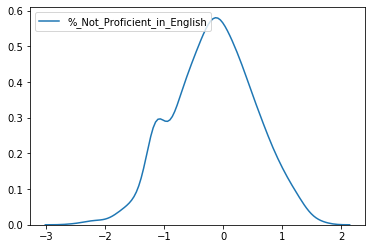

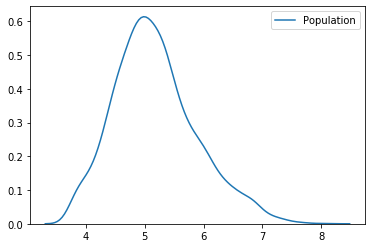

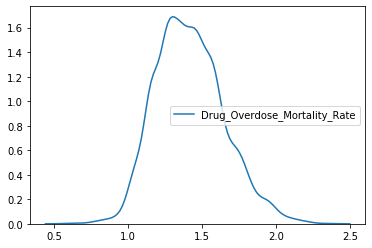

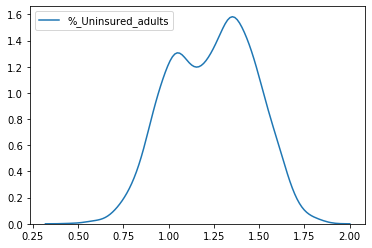

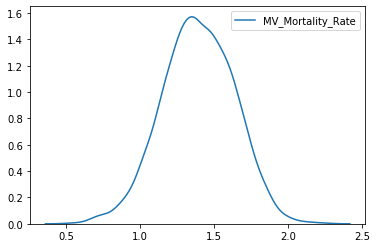

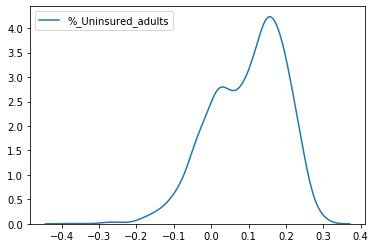

In [4]:
to_log = ["%_Not_Proficient_in_English", "Population" ,"Drug_Overdose_Mortality_Rate", "%_Uninsured_adults","MV_Mortality_Rate", "%_Uninsured_adults"]
# to_categories = ["Other_PCP_Rate","Population", "%_Rural"] #Maybe!
# ["%_Limited_Access_Healthy_Food"]   <= to many std away from mean at the lower end of the tail
for i, column in enumerate(to_log):
    df[column]=df[column].replace(0,0.1)
    df[column] = df[column].map(lambda x: np.log(np.sqrt(x)))
    plt.figure(i)
    sns.kdeplot(df[column])

#### Check for normality

In [5]:
#fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

#### Normalize numerical columns

In [9]:
for column in df.columns:
    if column in ["State","County"]:
        continue
    df[column] = scale(df[column])

In [10]:
df.head()

,State,Life_Expectancy,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,%_Limited_Access_Healthy_Food,Drug_Overdose_Mortality_Rate,MV_Mortality_Rate,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,-0.371324,-0.306073,0.718963,0.211897,0.977260,-0.075345,0.516505,-1.243045,0.472793,...,-0.211266,0.517840,0.238807,0.296842,0.406213,0.487033,-0.789993,0.101027,0.636198,-0.500545
1,Alabama,0.384829,-0.615404,-0.380349,0.309501,-0.136557,-0.338073,-0.366922,-0.092050,-0.146981,...,-0.857775,-0.010890,0.185683,0.338058,1.357614,-0.123367,0.276020,-0.333338,0.685643,-0.491667
2,Alabama,-0.554998,0.866368,1.162393,1.268450,2.436746,2.265321,0.348145,0.001419,0.531696,...,0.294698,0.117287,-1.098089,0.554329,-0.151158,-0.440395,0.028177,0.368536,-1.203501,0.326098
3,Alabama,-1.171938,2.574230,4.938856,0.326180,1.246113,0.497879,-0.746678,0.567374,0.917252,...,0.632007,1.094637,0.495963,-0.772784,-0.228131,-0.486459,-0.590598,-0.436054,-1.550998,0.344145
4,Alabama,-0.948817,0.814787,-0.182044,0.842233,1.015668,-0.648569,-0.709208,0.819087,0.952828,...,0.407134,0.838283,0.887764,-0.920292,0.437531,0.315453,-0.188704,0.689888,0.343799,1.036519


#### Turn State column into category

In [11]:
df["State"] = df["State"].astype('category')

#### Creating dummy variables

In [12]:
df["State"] = df["State"].cat.codes

In [13]:
from statsmodels.formula.api import ols
# Fitting the actual model
y = df["Life_Expectancy"].astype('float')
X = sm.add_constant(df.drop(["Life_Expectancy"], axis=1).astype('float'))
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Life_Expectancy   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     281.4
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        14:45:33   Log-Likelihood:                -2521.9
No. Observations:                3073   AIC:                             5096.
Df Residuals:                    3047   BIC:                             5253.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

/home/locsta/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Dropping columns with high p-values

In [15]:
to_drop = ["Infant_Mortality_Rate", "%_Uninsured_adults", "%_Disconnected_Youth", "%_Homeowners", "%_Severe_Housing_Cost_Burden", "Population", "%_Female"]
for col in to_drop:
    df = df.drop([col], axis=1)

In [17]:
y = df["Life_Expectancy"].astype('float')
X = sm.add_constant(df.drop(["Life_Expectancy"], axis=1).astype('float'))
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Life_Expectancy   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     389.6
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        14:49:17   Log-Likelihood:                -2527.5
No. Observations:                3073   AIC:                             5093.
Df Residuals:                    3054   BIC:                             5208.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

#### Verify non multicollinearity over 75%

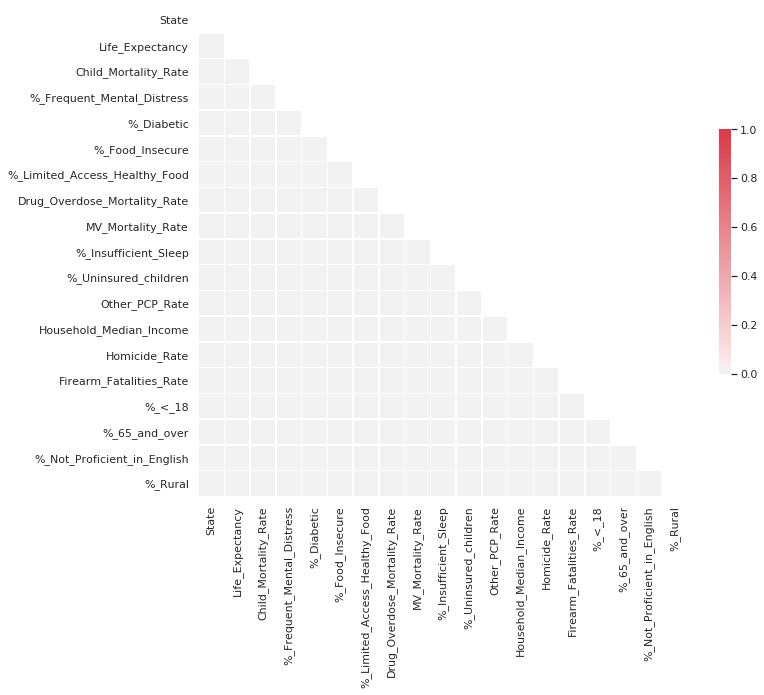

In [22]:
print_corr(df, 0.75)

### Cross-validation

In [23]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=10)

y = df["Life_Expectancy"].astype('float')
X = df.drop(["Life_Expectancy"], axis=1).astype('float')

baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

#### Baseline R-Squared

In [24]:
print(f"The baseline R-Squared is {baseline}")

The baseline R-Squared is 0.6901248692448776


### Feature Engineering

#### Interactions

In [25]:
from itertools import combinations
combinations = list(combinations(X.columns, 2))

In [26]:
interactions = []
data = X.copy()
for comb in combinations:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score, 3)))
            
print('Top 7 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7])
data = data.drop(["interaction"], axis=1)

Top 7 interactions: [('%_Diabetic', '%_Insufficient_Sleep', 0.698), ('%_Food_Insecure', '%_Uninsured_children', 0.695), ('%_Limited_Access_Healthy_Food', '%_<_18', 0.695), ('%_Food_Insecure', '%_<_18', 0.694), ('State', '%_Food_Insecure', 0.693), ('%_Frequent_Mental_Distress', '%_Diabetic', 0.693), ('%_Frequent_Mental_Distress', '%_Limited_Access_Healthy_Food', 0.693)]


#### Polynomial

In [27]:
polynomials = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
colors = ['yellow', 'lightgreen', 'blue']
for col in X_train.columns:
    for index, degree in enumerate([2, 3, 4]):
        #Instantiate PolynomialFeatures
        poly = PolynomialFeatures(degree)

        #Fit and transform X_train
        X_poly_train = poly.fit_transform(X_train)

        #Instantiate and fit a linear regression model to the polynomial transformed train features
        lm = LinearRegression()
        reg_poly = lm.fit(X_poly_train, y_train)

        #Transform the test data into polynomial features
        X_poly_test = poly.fit_transform(X_test)

        #Get predicted values for transformed polynomial test data  
        y_pred = reg_poly.predict(X_poly_test)

        #Evaluate model performance on test data
#         print("degree %d" % degree, r2_score(y_test, y_pred))
        
        if r2_score(y_test, y_pred) > baseline: polynomials.append((col, degree, round(r2_score(y_test, y_pred), 3)))
print('Top 10 polynomials: %s' %sorted(polynomials, key=lambda poly: poly[2], reverse=True)[:10])

Top 10 polynomials: [('State', 2, 0.692), ('Child_Mortality_Rate', 2, 0.692), ('%_Frequent_Mental_Distress', 2, 0.692), ('%_Diabetic', 2, 0.692), ('%_Food_Insecure', 2, 0.692), ('%_Limited_Access_Healthy_Food', 2, 0.692), ('Drug_Overdose_Mortality_Rate', 2, 0.692), ('MV_Mortality_Rate', 2, 0.692), ('%_Insufficient_Sleep', 2, 0.692), ('%_Uninsured_children', 2, 0.692)]


In [28]:
pprint('Top 10 polynomials: %s' %sorted(polynomials, key=lambda poly: poly[2], reverse=True)[:10])

("Top 10 polynomials: [('State', 2, 0.692), ('Child_Mortality_Rate', 2, "
 "0.692), ('%_Frequent_Mental_Distress', 2, 0.692), ('%_Diabetic', 2, 0.692), "
 "('%_Food_Insecure', 2, 0.692), ('%_Limited_Access_Healthy_Food', 2, 0.692), "
 "('Drug_Overdose_Mortality_Rate', 2, 0.692), ('MV_Mortality_Rate', 2, 0.692), "
 "('%_Insufficient_Sleep', 2, 0.692), ('%_Uninsured_children', 2, 0.692)]")


#### Adding Polymial features to X

In [29]:
for col in ['%_Frequent_Mental_Distress', '%_Diabetic']:
    poly = PolynomialFeatures(2, include_bias=False)
    X_transformed = poly.fit_transform(X_train[[col]])
    colnames= [col, col + '_' + '2']
    df = pd.concat([df.drop(col, axis=1), pd.DataFrame(X_transformed, columns=colnames)], axis=1)

In [30]:
df.head()

,State,Life_Expectancy,Child_Mortality_Rate,%_Food_Insecure,%_Limited_Access_Healthy_Food,Drug_Overdose_Mortality_Rate,MV_Mortality_Rate,%_Insufficient_Sleep,%_Uninsured_children,Other_PCP_Rate,...,Homicide_Rate,Firearm_Fatalities_Rate,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Rural,%_Frequent_Mental_Distress,%_Frequent_Mental_Distress_2,%_Diabetic,%_Diabetic_2
0,0,-0.371324,-0.306073,-0.075345,0.516505,-1.243045,0.472793,0.671477,-1.064571,-0.835218,...,-0.211266,0.517840,0.487033,-0.789993,0.101027,-0.500545,-1.591178,2.531848,-0.635855,0.404311
1,0,0.384829,-0.615404,-0.338073,-0.366922,-0.092050,-0.146981,0.041185,-0.816585,-0.449277,...,-0.857775,-0.010890,-0.123367,0.276020,-0.333338,-0.491667,-0.138004,0.019045,1.284521,1.649993
2,0,-0.554998,0.866368,2.265321,0.348145,0.001419,0.531696,1.315886,-0.926153,-0.958374,...,0.294698,0.117287,-0.440395,0.028177,0.368536,0.326098,0.555908,0.309033,1.169298,1.367258
3,0,-1.171938,2.574230,0.497879,-0.746678,0.567374,0.917252,1.215433,-1.017940,0.274072,...,0.632007,1.094637,-0.486459,-0.590598,-0.436054,0.344145,-0.388981,0.151306,-1.058337,1.120078
4,0,-0.948817,0.814787,-0.648569,-0.709208,0.819087,0.952828,0.681080,-0.754052,-1.043920,...,0.407134,0.838283,0.315453,-0.188704,0.689888,1.036519,-1.087268,1.182152,-0.674262,0.454630


In [31]:
full_model = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
full_model

0.6901248692448776

In [32]:
list(data.columns)

['State',
 'Child_Mortality_Rate',
 '%_Frequent_Mental_Distress',
 '%_Diabetic',
 '%_Food_Insecure',
 '%_Limited_Access_Healthy_Food',
 'Drug_Overdose_Mortality_Rate',
 'MV_Mortality_Rate',
 '%_Insufficient_Sleep',
 '%_Uninsured_children',
 'Other_PCP_Rate',
 'Household_Median_Income',
 'Homicide_Rate',
 'Firearm_Fatalities_Rate',
 '%_<_18',
 '%_65_and_over',
 '%_Not_Proficient_in_English',
 '%_Rural']